In [36]:
from pymongo import MongoClient
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.corpora import BleiCorpus
from gensim.models import LdaModel
from gensim import corpora
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import pos_tag
from sklearn.feature_extraction import text
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.cross_validation import ShuffleSplit
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import LSHForest
% matplotlib inline

In [34]:
class Corpus(object):
    def __init__(self, cursor, reviews_dictionary, corpus_path):
        self.cursor = cursor
        self.reviews_dictionary = reviews_dictionary
        self.corpus_path = corpus_path

    def __iter__(self):
        self.cursor.rewind()
        for review in self.cursor:
            yield self.reviews_dictionary.doc2bow(review["words"])

    def serialize(self):
        BleiCorpus.serialize(self.corpus_path, self, id2word=self.reviews_dictionary)

        return self


class Dictionary(object):
    def __init__(self, cursor, dictionary_path):
        self.cursor = cursor
        self.dictionary_path = dictionary_path

    def build(self):
        self.cursor.rewind()
        dictionary = corpora.Dictionary(review["words"] for review in self.cursor)
        dictionary.filter_extremes(keep_n=10000)
        dictionary.compactify()
        corpora.Dictionary.save(dictionary, self.dictionary_path)

        return dictionary


class Train:
    def __init__(self):
        pass

    @staticmethod
    def run(lda_model_path, corpus_path, num_topics, id2word):
        corpus = corpora.BleiCorpus(corpus_path)
        lda = LdaModel(corpus, num_topics=num_topics, id2word=id2word)
        lda.save(lda_model_path)

        return lda

In [7]:
def create_main_collection(filename):
    
    """
    Load data in from textfile into a mongo database; each record is a review.  
    If collection already exists make sure to drop the wine_info collection before the data is reloaded.
    """
    wine_info = client.wines.wine_info    
    
    with open(filename, 'r') as f:
        single_wine = {}
        i = 0
        for line in f:
            if i == 9:
                wine_info.save(single_wine)
                single_wine = {}
                i = 0
            else:
                row = line.split(':')
                try:
                    if row[0] == 'review/text':
                        row[1] = row[1].decode('latin-1').strip()
                        single_wine[row[0]] = row[1]
                    else:
                        single_wine[row[0]] = row[1].strip()
                except:
                    print row[1]
                    break
                i += 1

In [8]:
def consolidate_wines(dataframe):
    
    """
    Takes in a dataframe and groups by the wine name; creates lists containing the wine name, all of its reviews 
    concatenated into one string, the varietal, the year, and the average review points
    """
    
    review_text = []
    avg_review_points = []
    wine_name = []
    wine_varietal = []
    wine_year = []


    for wine, iterables in dataframe.groupby('wine/name'):
        
        if len(set(iterables['review/text'].values)) > 14:

            # append wine name
            wine_name.append(wine)
    
            # combine all wine reviews in one string and append
            review_text.append(' '.join(set(iterables['review/text'].values)))
    
            # append wine varietal
            wine_varietal.append(iterables['wine/variant'].values[0])
    
            # append wine year
            wine_year.append(iterables['wine/year'].values[0])
    
            # append average review score
            avg_review_points.append(np.nanmean(iterables['review/points'].values))   
        
    keys = ['wine/name', 'wine/variant', 'review/text', 'review/points', 'wine/year']
    
    individual_wines = zip(wine_name, wine_varietal, review_text, avg_review_points, wine_year)
        
    return [dict(zip(keys, wine)) for wine in individual_wines]

In [15]:
def vectorize_text(x):
    
    added_stop_words = ['wine', 'nose', 'br', 'years', 'time', 'hour', 'bottle', '\' \'', '\'s', '\'m', 'n\'t', 'i', 'ca', \
      'come', 'came', 'did', 'just', 'wines', 'best', 'winery', '``', '\'\'', '\'ve', '...', 'winemaker', 'qpr']
    added_stop_words.extend([str(i) for i in range(2012)])
    added_stop_words.extend(string.punctuation)  
    stop_words = text.ENGLISH_STOP_WORDS.union(added_stop_words)

    vectorizer = text.TfidfVectorizer(min_df=1, stop_words=stop_words, ngram_range=(1,2))
    tfidf_reviews = vectorizer.fit_transform(x)
    print 'Shape of resulting tf-idf vectors: {0}'.format(tfidf_reviews.shape)
    
    return tfidf_reviews, vectorizer

In [16]:
def n_component_pca(n, tfidf_reviews):
    svd = TruncatedSVD(n_components=n)
    reviews = svd.fit(tfidf_reviews).transform(tfidf_reviews)
    print 'Shape of resulting principal components: {0}'.format(reviews.shape)
    return svd, reviews

In [31]:
def find_nearest_wines(text):
    vec_reviews = vect_all.transform([text])

    svd_reviews = svd_all.transform(vec_reviews)
    neighbors = lshf.kneighbors(svd_reviews)

    for i in neighbors[1][0]:
        for food in food_list:
            if food in wines[i]['review/text']:
                print food
                print
        print wines[i]
        print

In [37]:
def load_stopwords():
    more_stopwords = ['\'s', 'wine', 'nose', 'br', 'drink', 'year', 'time', 'day', 'hour', 'wines', 'winery' \
    'glass', 'drank']
    stopwords = {}
    with open('stopwords.txt', 'rU') as f:
        for line in f:
            stopwords[line.strip()] = 1
        for char in string.punctuation:
            stopwords[char] = 1
    for more_words in more_stopwords:
        stopwords[more_words] = 1

    return stopwords

In [38]:
def create_topic_collection(reviews, color, corpus_name):
    
    for review in reviews:

        cursor = cgt14.find({'review/text': review})
        single_review = cursor.next()

        words = []
        sentences = sent_tokenize(single_review['review/text'].lower())

        for sentence in sentences:
            tokens = word_tokenize(sentence)
            review_text = [word for word in tokens if word not in stopwords]
            tagged_text = pos_tag(review_text)

            for word, tag in tagged_text:
                words.append({"word": word, "pos": tag})

        lem= WordNetLemmatizer()

        nouns = []
        words = [word['word'] for word in words if word['pos'] in ["NN", "JJ"]]

        for word in words:
            nouns.append(lem.lemmatize(word))

        corpus_name.insert({
            "wine/name": review["wine/name"],
            "wine/variant": review["wine/variant"],
            "review/points": review['review/points'],
            "review/text": review["review/text"],
            "words": nouns
        })

#### Creates main collection in MongoDB from original text file of 2,000,000 reviews.  Each object is one wine review.

In [2]:
#create_main_collection('cellartracker.txt')

In [9]:
client = MongoClient()
wine_info = client.wines.wine_info

In [13]:
# Loads in all reviews
all_reviews = wine_info.find({}, {'_id': 0})

# Create dataframe of all reviews; turn 'N/A' into NaN in the points column and change the datatype to float
all_df = pd.DataFrame(list(all_reviews))
all_df.replace({'review/points': {'N/A': np.nan}}, inplace=True)
all_df['review/points'] = all_df['review/points'].astype(float)

#### The below creates a consolidated collection of wines.  It combines all reviews for a particular wine into one string so that there is only one entry in the database per individual wine.  I only keep wines that have fifteen or more reviews.

In [14]:
# Create new collection and add new documents
consolidated_wines = client.wines.consolidated_gt14_wines
cons_wines = consolidate_wines(all_df)
for wine in cons_wines:
    consolidated_gt14_wines.save(wine)

#### PULL IN WINES HAVING 15 OR MORE REVIEWS THAT ARE OF YEAR 1990 OR OLDER

In [17]:
cgt14 = client.wines.consolidated_gt14_wines
wine_cursor = cgt14.find({'$and': [{'wine/year': {'$gt':'1990'}}, {'wine/year': {'$ne': 'N/A'}}]}, {'_id': 0})
wines = [wine for wine in wine_cursor]

#### PRINCIPAL COMPONENT ANALYSIS, VISUALIZATION, AND LINEAR SVM CLASSIFICATION

In [20]:
reviews = [wine['review/text'] for wine in wines]
tfidf_all, vect_all = vectorize_text(reviews)

Shape of resulting tf-idf vectors: (23078, 3612744)


#### Break down reviews to two principal components for visualization

In [23]:
svd_2, reviews_2 = n_component_pca(2, tfidf_all)

df = pd.DataFrame(list(wines))

reds = ['Cabernet Sauvignon', 'Merlot', 'Cabernet Franc', 'Malbec', 'Shiraz, Syrah', 'Syrah', 'Red Blend', 'Grenache',
        'Mourvedre', 'Rhone Red Blend', 'Pinot Noir', 'Gamay', 'Zinfandel', 'Petite Sirah', 'Tempranillo', 'Nebbiolo',
        'Dolcetto', 'Nero d\'Avola', 'Primitivo', 'Barbera', 'Sangiovese', 'Carmenere', 'Pinotage', 'Red Bordeaux Blend', \
       ]

white = ['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Champagne Blend', 'Cabernet Franc', \
        'Gew&#252;rztraminer', 'Viognier', 'Chenin Blanc', 'Pinot Gris']

color = []

for variant in df['wine/variant'].values:
    if variant in reds:
        color.append('r')
    elif variant in white:
        color.append('y')
    else:
        color.append('w')

Shape of resulting principal components: (23078, 2)


#### LINEAR SVM CLASSIFICATION 

Length of X train set: 15462
Length of y train set: 15462
Length of X test set: 7616
Length of y test set: 7616
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      6185
    class 1       1.00      1.00      1.00      1431

avg / total       1.00      1.00      1.00      7616

Cross Validation Accuracy: 1.00 (0.00)


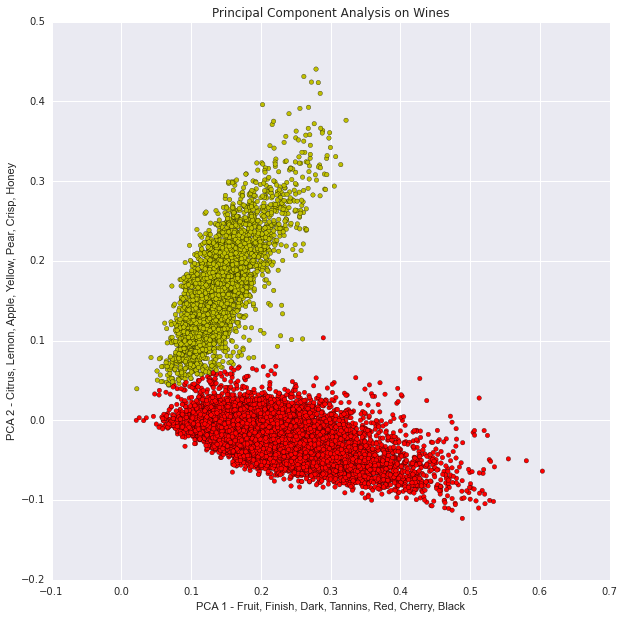

In [35]:
X = [(array, color) for (array, color) in zip(reviews_2, color) if color in ['r','y']]
y = []

for wine in X:
    if wine[1] == 'r':
        y.append(0)
    else:
        y.append(1)

X = [array for (array, color) in X]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print 'Length of X train set: {0}'.format(len(X_train))
print 'Length of y train set: {0}'.format(len(y_train))
print 'Length of X test set: {0}'.format(len(X_test))
print 'Length of y test set: {0}'.format(len(y_test))

svm = LinearSVC(penalty='l2').fit(X_train, y_train)
y_pred = svm.predict(X_test)

print metrics.classification_report(y_test, y_pred, target_names = ['class 0', 'class 1'])

cv = ShuffleSplit(len(X), n_iter=7, test_size=0.30, random_state=0)
cv_accuracy = cross_validation.cross_val_score(svm, X, y, scoring='accuracy', cv=cv)
print 'Cross Validation Accuracy: {0:0.2f} ({1:0.2f})'.format(cv_accuracy.mean(), cv_accuracy.std())

classified_wines = svm.predict(reviews_2)

color = []
for num in classified_wines:
    if num == 0:
        color.append('r')
    else:
        color.append('y')

plt.figure(figsize=(10,10))       
plt.scatter(reviews_2[:,0], reviews_2[:,1], c=color)
plt.xlabel('PCA 1 - Fruit, Finish, Dark, Tannins, Red, Cherry, Black')
plt.ylabel('PCA 2 - Citrus, Lemon, Apple, Yellow, Pear, Crisp, Honey')
plt.title('Principal Component Analysis on Wines')

#### LOCALITY SENSITIVE HASHING - NEAREST NEIGHBORS SEARCH

In [29]:
## Actual analysis done with 25 components
svd_all, all_reviews = n_component_pca(25, tfidf_all)

lshf = LSHForest(n_neighbors = 5)
lshf.fit(all_reviews)

Shape of resulting principal components: (23078, 25)


LSHForest(min_hash_match=4, n_candidates=50, n_estimators=10, n_neighbors=5,
     radius=1.0, radius_cutoff_ratio=0.9, random_state=None)

In [ ]:
# Create a food list to check if reviews contain food pairings
food_list = ['asparagus', 'barbecue', 'beef', 'broccoli', 'sprouts', 'brisket', \
             'burrito', 'casserole', 'cheese', 'chicken', 'chili', 'greens', 'crab', \
             'dessert', 'fillet', 'fish', 'gyro', 'halibut', 'burger', 'hot dog', 'ice cream', 'kale', \
             'beans', 'lamb', 'lasagna', 'legumes', 'lentils', 'lobster', 'macaroni', \
             'potato', 'mozzarella', 'pizza', 'mussels', 'noodles', 'oyster', 'pasta', 'squash', \
             'poached', 'pork', 'prime rib', 'pretzel', 'quinoa', 'ravioli', 'roast', \
             'salami', 'salmon', 'sausage', 'scallops', 'shrimp', 'soup', 'spaghetti', 'spareribs', 'spinach', \
             'peas', 'squid', 'steak', 'stir-fry', 'sushi', 'tapioca', 'teriyaki', 'turkey', 'turnip', \
             'veal', 'venison', 'yam', 'zucchini', 'fried']

In [32]:
find_nearest_wines('blueberry smoke licorice raspberry')

{u'wine/name': u'2005 Herman Story Syrah White Hawk', u'review/points': 93.76923076923077, u'wine/year': u'2005', u'wine/variant': u'Syrah', u'review/text': u"Omg, why didn't I buy more of this when I had the chance? Great wine, incredible qpr. Where do I get more now? If any wine can be called voluptuous, this is it. Rich, full bodied, sweet, complex, with not a flavor out of place. You just want to keep swirling it in your mouth. Folks couldn't stop refilling their glasses. One person at the table, who had come over without her husband enjoyed it so much (and so much of it) that she went home early and jumped her hubby's bones. Now he's begging to know where to get more Popped and poured. Inky, almost black in the glass. Huge nose of blackberry, plum, licorice, and blueberry. Blackberry and blueberry on the palate with a hint of pepper. Starts slightly hot but dissapates quickly with air. Long finish with sweet tannins. Incredible balance and mouthfeel. Absolutely oustanding, can alr

#### TOPIC MODELING

In [42]:
dictionary_path = "models/dictionary.dict"
corpus_path = "models/corpus.lda-c"
lda_model_path = "models/lda_model_topics.lda"
lda_num_topics = 20

#### White wine topic modeling.

In [41]:
white_collection = client.wines.white_corpus_collection
reviews_cursor = white_collection.find()

In [43]:
dictionary = Dictionary(reviews_cursor, dictionary_path).build()
Corpus(reviews_cursor, dictionary, corpus_path).serialize()
Train.run(lda_model_path, corpus_path, lda_num_topics, dictionary)

In [44]:
dictionary = corpora.Dictionary.load(dictionary_path)
corpus = corpora.BleiCorpus(corpus_path)
lda = LdaModel.load(lda_model_path)

i = 0
for topic in lda.show_topics(num_topics=lda_num_topics):
    print '#' + str(i) + ': ' + topic
    i += 1

#0: 0.012*petrol + 0.007*sweetness + 0.006*young + 0.005*stone + 0.005*beautiful + 0.005*spice + 0.005*note + 0.005*lime + 0.004*apricot + 0.004*wonderful
#1: 0.039*champagne + 0.017*yeasty + 0.016*mousse + 0.013*fine + 0.013*nv + 0.012*yeast + 0.010*bread + 0.009*toasty + 0.008*toast + 0.007*creamy
#2: 0.011*oak + 0.007*young + 0.006*beautiful + 0.006*big + 0.005*pineapple + 0.005*length + 0.005*vanilla + 0.005*age + 0.005*texture + 0.005*orange
#3: 0.019*champagne + 0.008*style + 0.006*oak + 0.006*fine + 0.006*spice + 0.005*texture + 0.005*yeasty + 0.005*big + 0.005*mousse + 0.005*wonderful
#4: 0.012*le + 0.008*une + 0.007*avec + 0.007*en + 0.007*la + 0.007*nez + 0.006*oak + 0.006*chardonnay + 0.006*bouche + 0.005*vin
#5: 0.010*champagne + 0.008*orange + 0.007*fine + 0.007*caramel + 0.006*pineapple + 0.006*sweetness + 0.006*apricot + 0.006*texture + 0.006*beautiful + 0.006*golden
#6: 0.010*oak + 0.007*texture + 0.006*length + 0.005*beautiful + 0.005*blanc + 0.005*note + 0.005*alcohol

#### Red wine topic modeling.

In [45]:
dictionary_path = "models/red_dictionary.dict"
corpus_path = "models/red_corpus.lda-c"
lda_model_path = "models/red_lda_model_topics.lda"
lda_num_topics = 20

In [46]:
red_collection = client.wines.red_corpus_collection
reviews_cursor = red_collection.find()

In [47]:
dictionary = Dictionary(reviews_cursor, dictionary_path).build()
Corpus(reviews_cursor, dictionary, corpus_path).serialize()
Train.run(lda_model_path, corpus_path, lda_num_topics, dictionary)

In [48]:
dictionary = corpora.Dictionary.load(dictionary_path)
corpus = corpora.BleiCorpus(corpus_path)
lda = LdaModel.load(lda_model_path)

i = 0
for topic in lda.show_topics(num_topics=lda_num_topics):
    print '#' + str(i) + ': ' + topic
    i += 1

#0: 0.009*beautiful + 0.007*cassis + 0.007*powerful + 0.007*potential + 0.007*licorice + 0.007*coffee + 0.006*decant + 0.006*long + 0.006*silky + 0.006*tight
#1: 0.025*cdp + 0.016*garrigue + 0.011*brett + 0.008*licorice + 0.008*leather + 0.007*barnyard + 0.006*vintage + 0.006*tight + 0.006*fresh + 0.006*pegau
#2: 0.042*syrah + 0.013*rhone + 0.012*meat + 0.010*smoke + 0.008*floral + 0.008*bacon + 0.007*licorice + 0.007*meaty + 0.006*tar + 0.005*olive
#3: 0.036*bordeaux + 0.020*cassis + 0.017*cedar + 0.013*tobacco + 0.010*leather + 0.008*currant + 0.008*pencil + 0.007*vintage + 0.007*dry + 0.006*green
#4: 0.019*cassis + 0.016*bordeaux + 0.013*elegant + 0.012*fresh + 0.012*cabernet + 0.011*vintage + 0.011*coffee + 0.009*tobacco + 0.008*beautiful + 0.008*merlot
#5: 0.029*shiraz + 0.019*blueberry + 0.013*aussie + 0.012*bomb + 0.010*heat + 0.010*hot + 0.010*jammy + 0.009*huge + 0.008*inky + 0.007*thick
#6: 0.019*qpr + 0.011*fruity + 0.011*decent + 0.010*food + 0.009*buy + 0.008*easy + 0.008*